<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Методы машинного обучения</center></h1>
<h2><center>Семинар: линейные модели классификации</center></h2>
<h2><center>Методы понижения размерности</center></h2>

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Логистическая регрессия

## Игрушечный пример

Сгенерируем выборку и опробуем логистическую регрессию

In [3]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) + [2, 2],
          np.random.randn(20, 2) + [-2, -2]]
y = [-1] * 20 + [1] * 20

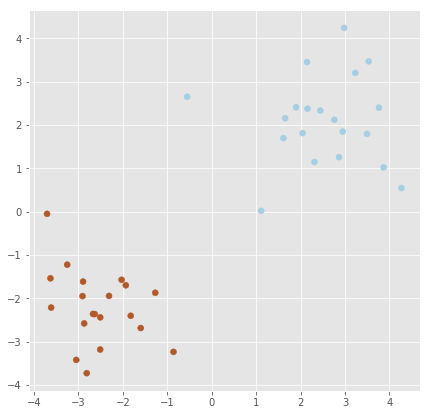

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0],
           X[:, 1],
           c=y,
           cmap=plt.cm.Paired)

In [5]:
from sklearn.linear_model import LogisticRegression

Обучим логистическую регрессию на этих данных и нарисуем разделяющую гиперплоскость

In [6]:
model = LogisticRegression(C=1.0, 
                           fit_intercept=True, 
                           penalty='l2')
model.fit(X, y)

/Users/andrey.shestakov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
print('w_0 = %f' % model.intercept_)
print('w_1, w_2 = ', model.coef_)

w_0 = -0.183954
w_1, w_2 =  [[-1.06097157 -1.00171289]]


In [8]:
# Нарисуем эту гиперплоскость
w_0 = model.intercept_[0]
w_1 = model.coef_[0][0]
w_2 = model.coef_[0][1]

x_1 = np.linspace(-4, 4, 10)
x_2 = - (w_0 + w_1*x_1)/w_2

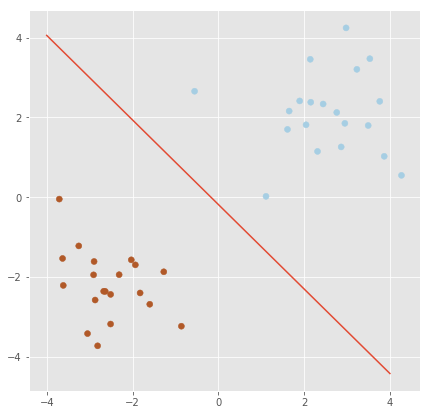

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0],
           X[:, 1],
           c=y,
           cmap=plt.cm.Paired)
plt.plot(x_1, x_2)

## Пример с текстами

Возьмем текстовые данные [отсюда](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/). Архив содержит 3 файла с положительными и отрицательными отзывами с ресурсов
* imdb.com
* amazon.com
* yelp.com

Формат файла следующий:
<отзыв>\t<метка>\n


### Задача
1. Загрузите тексты и метки классов в разные переменные
2. Выберите меру качества классификации
3. Обучите логистическую (без подбора гиперпараметров). Тексты представляются в виде мешка слов
4. Выведите наиболее значимые слова из текста
5. С помощью кросс-валидации найдите хорошие значения гиперпараметров для `CountVectorizer` и `LogisticRegression`

In [10]:
df = pd.read_csv('data/sentiment/imdb_labelled.txt', sep='\t', header=None, names=['text', 'label'])

In [11]:
df.head()

,text,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [32]:
model = Pipeline([
    ('vect', CountVectorizer(max_df=0.95, stop_words='english', ngram_range=(2,2))),
    ('clf', LogisticRegression())
])

In [33]:
X = df.text.values
y = df.label.values

In [34]:
model.fit(X, y)

/Users/andrey.shestakov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=1,
        ngram_range=(2, 2), preprocessor=None, stop_words='english',
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [35]:
coefs = model.named_steps['clf'].coef_[0] # Веса линейной регрессии для каждого словa
words = model.named_steps['vect'].get_feature_names()

In [36]:
word_coefs = pd.Series(index=words, data=coefs).sort_values()

In [37]:
word_coefs

waste time               -0.945444
bad film                 -0.801509
avoid costs              -0.655693
just bad                 -0.621132
don waste                -0.585915
film just                -0.565970
worst series             -0.554764
90 minutes               -0.549202
hour half                -0.545175
cover girl               -0.521187
story stupid             -0.513814
avoid avoid              -0.512680
movie pretty             -0.488534
ve seen                  -0.462487
just awful               -0.456271
acting bad               -0.447700
film started             -0.444112
really bad               -0.424706
hate movies              -0.418471
just didn                -0.414149
action scenes            -0.413278
couldn seriously         -0.393361
worse ticker             -0.393361
just lame                -0.393361
plot storyline           -0.393361
just painful             -0.393361
great disappointment     -0.393361
script script            -0.393361
plot whatsoever     

# Методы понижения размерности

In [38]:
# Load data
df_wine = pd.read_csv('data/winequality-red.csv', sep=';')

# Make classification target feature
df_wine.loc[:, 'quality_cat'] = (df_wine.quality > 5).astype(int)
df_wine = df_wine.drop('quality', axis=1)

# Get descriptive and target features
X = df_wine.iloc[:, :-1].values
y = df_wine.iloc[:, -1].values

In [39]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


## Recursive Feature Elimination

In [40]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [48]:
model_rfe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RFECV(LogisticRegression(), step=1, cv=cv, verbose=1, scoring='roc_auc'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [49]:
model_rfe.fit(X, y)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estima

/Users/andrey.shestakov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrey.shestakov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrey.shestakov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrey.shestakov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrey.shestakov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RFECV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_clas...m_start=False),
   min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
   verbose=1))])

In [52]:
rfe = model_rfe.named_steps['clf']

In [55]:
rfe.grid_scores_ # Качество для 1, 2, 3 и тп признаков

array([0.75720164, 0.7955729 , 0.80091782, 0.81279034, 0.81248978,
       0.81463012, 0.8164726 , 0.81848756, 0.81790802, 0.81704451,
       0.81717928])

In [61]:
rfe.support_

array([ True,  True,  True, False,  True,  True,  True, False, False,
        True,  True])

In [56]:
num_of_features = range(1, 12)

Text(0,0.5,'ROC AUC')

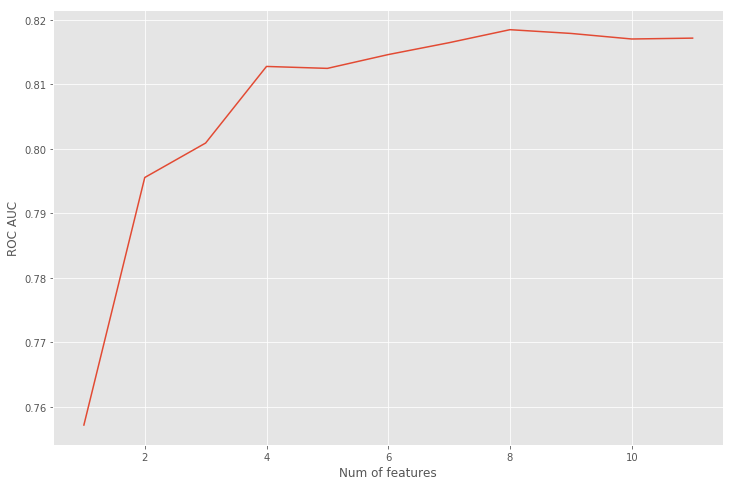

In [58]:
plt.plot(num_of_features, rfe.grid_scores_ )
plt.xlabel('Num of features')
plt.ylabel('ROC AUC')

## PCA

Попробуем получить PCA разными способами

## PCA через sklearn

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=5)

## PCA через ковариационную матрицу

In [ ]:
from numpy.linalg import eig

## Оценка качества при разных количествах компонент

Реализуйте 2 пайплайнк:
    * StandartScaler + LogisticRegression
    * StandartScaler + PCA + LogisticRegression

Оцените качество пайплайна с PCA при разных количествах компонент и сравните его с первым

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

## Singular Value Decomposition

Для любой матрицы $A$ размера $n \times m$ и ранга $r$ можно найти разложение вида:
$$ A = U \Sigma V^\top ,$$
где 
* $U$ - унитарная матрица, состоящая из собственных векторов $AA^\top$
* $V$ - унитарная матрица, состоящая из собственных векторов $A^\top A$
* $\Sigma$ - диагональная матрица с сингулярными числами $s_i = \sqrt{\lambda_i}$

<center><img src='img/svd.jpg' width=600></center>

## SVD via PCA
Матрицы $U$ и $V$ ортогональны и могут быть использованы для перехода к ортогональному базису:
$$ AV = U\Sigma $$

<center><img src='img/pca_svd.png' width=600></center>

In [ ]:
from numpy.linalg import svd

## Рационы питания в странах

* Загрузите набор данных о пищевом рационе в разных странах мира `diet.csv`
* Примените на данных PCA с 2 компонентами
* Изобразите объекты в сжатом пространстве

In [162]:
df = pd.read_csv('data/diet.csv', sep=';')

* Скорее всего вы обнаружите некоторые выбросы, с этим ничего не поделать - PCA чувствителен к выбросам
* Удалите объекты-выборосы и повторите процедуру

# PCA для текстов
#### Он же Latent Semantic Index или Latent Semantic Allocation

* Когда мы работаем с текстами, бы обычно переходим к модели мешка слов
* Что если мы ходим применить для текстов PCA?
* Центрировать данные мы не можем, так как тогда наша огромная матрица с признаками будет плотной, а значит будет очень много весить
* Давайте не будем центрировать! =D

In [1]:
from sklearn.decomposition import TruncatedSVD

# T-SNE

#### Задание
Сожмите признаковое пространство данных с цифрами с помощью tsne.

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
## Your Code Here